# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
 - train.csv
 - test.csv

## Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Требования к решению:

1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

## Сроки сдачи:

Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга,
ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## Описание датасета:

 - Id - идентификационный номер квартиры
 - DistrictId - идентификационный номер района
 - Rooms - количество комнат
 - Square - площадь
 - LifeSquare - жилая площадь
 - KitchenSquare - площадь кухни
 - Floor - этаж
 - HouseFloor - количество этажей в доме
 - HouseYear - год постройки дома
 - Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
 - Social_1, Social_2, Social_3 - социальные показатели местности
 - Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
 - Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
 - Price - цена квартиры

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

### Создание функций

Переводим категориальные признаки dataseth в бинарные - 

In [160]:
def to_bin(column, df):
    df[column] = np.where(df[column] == 'A', 0, 1)
    return df[column].value_counts()

Для удаления выбросов - 

In [161]:
def out_removal(column, df):
    X1 = df[column].quantile(0.25)
    X2 = df[column].quantile(0.75)
    IQR = X2 - X1
    df.drop(df[(df[column] < (X1 - 1.5 * IQR)) | (df[column] > (X1 + 1.5 * IQR))].index, inplace = True)

Для построения диаграммы рассеяния - 

In [162]:
def scatter(column_1, column_2, df):
    plt.scatter(df[column_1], df[column_2])
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.show()

### Загрузка dataseth

In [163]:
df = pd.read_csv('train.csv')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [164]:
df.shape

(10000, 20)

### Получаем информацию о dataseth

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [166]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [167]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Выведим max значение HouseYear отдельно - 

In [168]:
df['HouseYear'].max()

20052011

Удаляем все записи в которых HouseYear > 2019

In [169]:
df.drop(df[(df['HouseYear'] > 2019)].index, inplace = True)
df.shape

(9979, 20)

Посмотрим категориальные признаки df - 

In [170]:
df.describe(include = 'object')

,Ecology_2,Ecology_3,Shops_2
count,9979,9979,9979
unique,2,2,2
top,B,B,B
freq,9882,9704,9158


В dataseth их 3

In [171]:
df['Ecology_2'].value_counts()

B    9882
A      97
Name: Ecology_2, dtype: int64

In [172]:
df['Ecology_3'].value_counts()

B    9704
A     275
Name: Ecology_3, dtype: int64

In [173]:
df['Shops_2'].value_counts()

B    9158
A     821
Name: Shops_2, dtype: int64

Заменим их на бинарные - 

In [174]:
to_bin('Ecology_2', df)

1    9882
0      97
Name: Ecology_2, dtype: int64

In [175]:
to_bin('Ecology_3', df)

1    9704
0     275
Name: Ecology_3, dtype: int64

In [176]:
to_bin('Shops_2', df)

1    9158
0     821
Name: Shops_2, dtype: int64

### Визуальный анализ целевой переменной

Text(0.5, 1.0, 'Распределение целевой переменной Price')

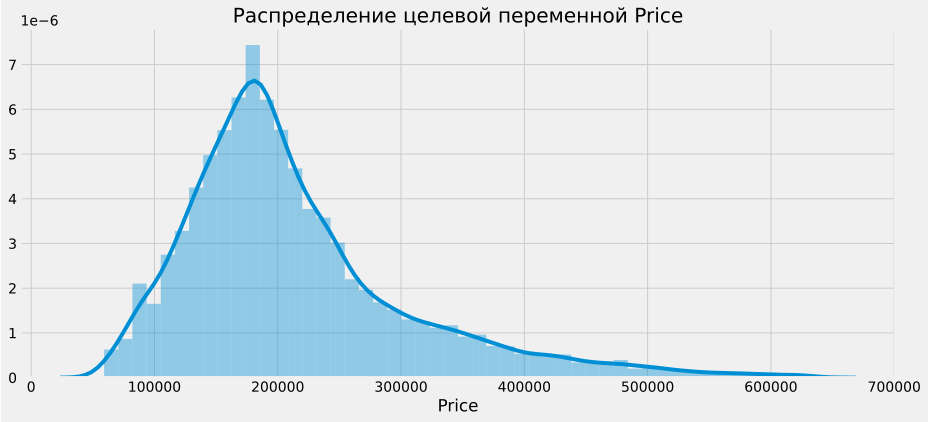

In [177]:
plt.figure(figsize = (14, 6))
sns.distplot(df['Price'])
plt.title('Распределение целевой переменной Price')

### Обработка пропусков

In [178]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4790
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [179]:
round(df.isna().sum() * 100 / df.shape[0], 1)

Id                0.0
DistrictId        0.0
Rooms             0.0
Square            0.0
LifeSquare       21.2
KitchenSquare     0.0
Floor             0.0
HouseFloor        0.0
HouseYear         0.0
Ecology_1         0.0
Ecology_2         0.0
Ecology_3         0.0
Social_1          0.0
Social_2          0.0
Social_3          0.0
Healthcare_1     48.0
Helthcare_2       0.0
Shops_1           0.0
Shops_2           0.0
Price             0.0
dtype: float64

Healthcare_1 - пропущено около половины значений; уберу этот признак из dataseth - 

In [180]:
del df['Healthcare_1']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9979 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9979 non-null   int64  
 1   DistrictId     9979 non-null   int64  
 2   Rooms          9979 non-null   float64
 3   Square         9979 non-null   float64
 4   LifeSquare     7866 non-null   float64
 5   KitchenSquare  9979 non-null   float64
 6   Floor          9979 non-null   int64  
 7   HouseFloor     9979 non-null   float64
 8   HouseYear      9979 non-null   int64  
 9   Ecology_1      9979 non-null   float64
 10  Ecology_2      9979 non-null   int32  
 11  Ecology_3      9979 non-null   int32  
 12  Social_1       9979 non-null   int64  
 13  Social_2       9979 non-null   int64  
 14  Social_3       9979 non-null   int64  
 15  Helthcare_2    9979 non-null   int64  
 16  Shops_1        9979 non-null   int64  
 17  Shops_2        9979 non-null   int32  
 18  Price   

In [181]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

LifeSquare - пропущена 5-ая часть значений; проверим есть ли корреляция с признаком Square - 

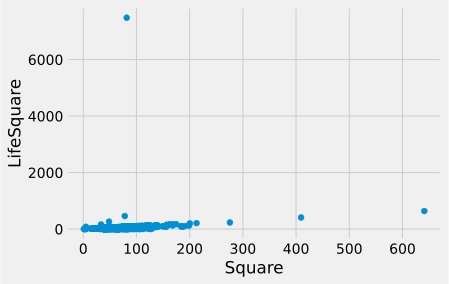

In [184]:
scatter('Square','LifeSquare', df)

Удалим очевидные выбросы и еще раз проверим наличие корреляции - 

In [185]:
df.drop(df[(df['LifeSquare'] > 800)].index, inplace = True)

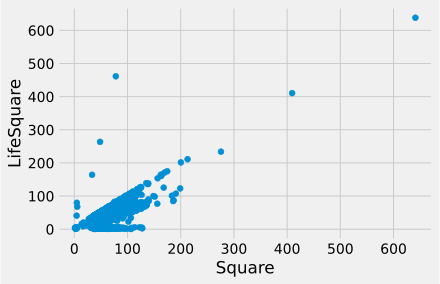

In [186]:
scatter ('Square','LifeSquare',df)

Значения признаков Square и LifeSquare коррелируют;

Доля средней жилой площади от средней общей площади - 

In [187]:
df[['Square', 'LifeSquare']].dropna().mean()

Square        55.221408
LifeSquare    36.234754
dtype: float64

In [192]:
coef = round(df[['Square', 'LifeSquare']].dropna().mean()[1] / df[['Square', 'LifeSquare']].dropna().mean()[0], 2)
coef

0.66

Заполним пропуски LifeSquare произведениями значений Square на коэффициент, вычесленный выше - 

In [194]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coef
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9978 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9978 non-null   int64  
 1   DistrictId     9978 non-null   int64  
 2   Rooms          9978 non-null   float64
 3   Square         9978 non-null   float64
 4   LifeSquare     9978 non-null   float64
 5   KitchenSquare  9978 non-null   float64
 6   Floor          9978 non-null   int64  
 7   HouseFloor     9978 non-null   float64
 8   HouseYear      9978 non-null   int64  
 9   Ecology_1      9978 non-null   float64
 10  Ecology_2      9978 non-null   int32  
 11  Ecology_3      9978 non-null   int32  
 12  Social_1       9978 non-null   int64  
 13  Social_2       9978 non-null   int64  
 14  Social_3       9978 non-null   int64  
 15  Helthcare_2    9978 non-null   int64  
 16  Shops_1        9978 non-null   int64  
 17  Shops_2        9978 non-null   int32  
 18  Price   

### Обработка выбросов

In [195]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,8382.023351,50.367007,1.890659,56.308029,36.996686,6.270295,8.528863,12.600822,1984.795350,0.118921,0.990279,0.972439,24.696332,5353.916015,8.046703,1.319603,4.234215,0.917719,214082.733246
std,4860.356229,43.593478,0.839638,21.066545,19.343028,28.591544,5.242808,6.770461,18.363262,0.119075,0.098122,0.163718,17.537731,4008.278521,23.852614,1.493556,4.809508,0.274806,92848.814305
min,0.000000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4167.250000,20.000000,1.000000,41.769384,24.752124,1.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153848.548426
50%,8392.500000,35.000000,2.000000,52.502558,33.561111,6.000000,7.000000,13.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192180.997752
75%,12593.500000,75.000000,2.000000,65.891996,45.151326,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249089.505423
max,16798.000000,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2019.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


Визуализируем выбросы оставшихся и не бинарных признаков - 

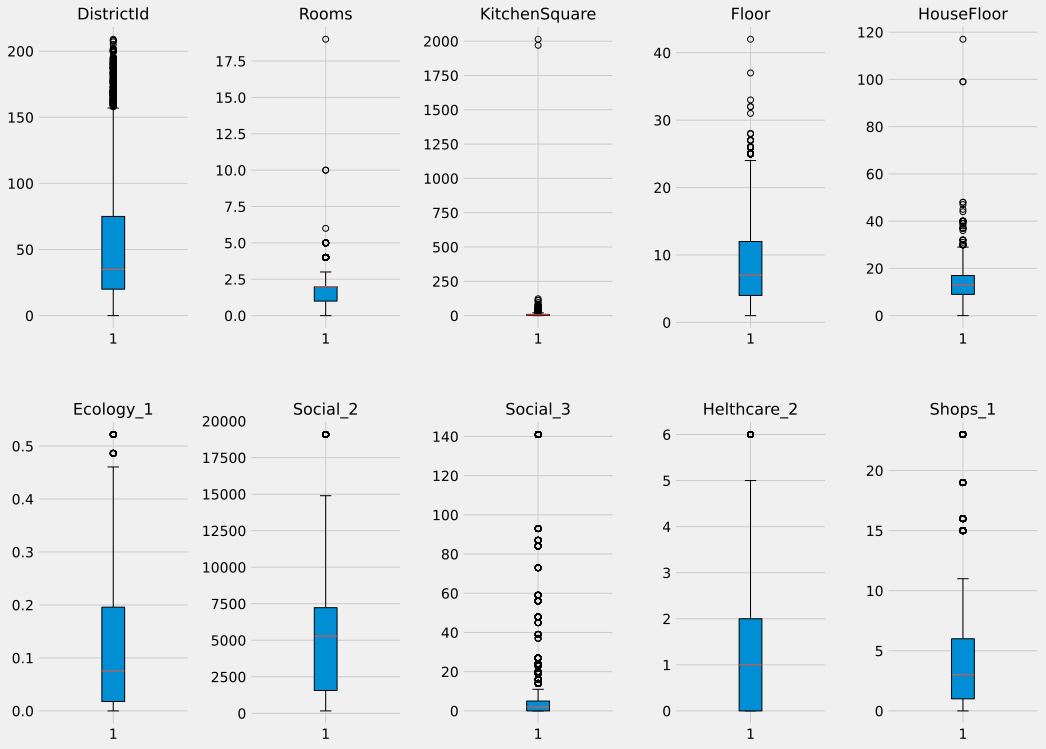

In [199]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (16, 12))
axs[0, 0].boxplot(df['DistrictId'], patch_artist = True)
axs[0, 0].set_title('DistrictId', fontsize = 16)

axs[0, 1].boxplot(df['Rooms'], patch_artist = True)
axs[0, 1].set_title('Rooms', fontsize = 16)

axs[0, 2].boxplot(df['KitchenSquare'], patch_artist = True)
axs[0, 2].set_title('KitchenSquare', fontsize = 16)

axs[0, 3].boxplot(df['Floor'], patch_artist = True)
axs[0, 3].set_title('Floor', fontsize = 16)

axs[0, 4].boxplot(df['HouseFloor'], patch_artist = True)
axs[0, 4].set_title('HouseFloor', fontsize = 16)

axs[1, 0].boxplot(df['Ecology_1'], patch_artist = True)
axs[1, 0].set_title('Ecology_1', fontsize = 16)

axs[1, 1].boxplot(df['Social_2'], patch_artist = True)
axs[1, 1].set_title('Social_2', fontsize = 16)

axs[1, 2].boxplot(df['Social_3'], patch_artist = True)
axs[1, 2].set_title('Social_3', fontsize = 16)

axs[1, 3].boxplot(df['Helthcare_2'], patch_artist = True)
axs[1, 3].set_title('Helthcare_2', fontsize = 16)

axs[1, 4].boxplot(df['Shops_1'], patch_artist = True)
axs[1, 4].set_title('Shops_1', fontsize = 16)

fig.subplots_adjust(hspace = 0.3, wspace = 0.4)
plt.show()

Удалим записи с большими выбросами в парметре KitchenSquare - 

In [200]:
df.drop(df[(df['KitchenSquare'] > 1750)].index, inplace = True)
df.shape

(9976, 19)

### Ковариация и корреляция данных

Проверим как признаки влияют друг на друга

Линейный коэффициент корреляции - 

In [201]:
df.corr()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
Id,1.000000,0.012966,-0.006211,-0.010232,-0.005465,0.010148,0.001472,-0.007969,0.003049,0.018460,0.003048,-0.005505,-0.000248,-0.001512,-0.009144,0.001540,-0.008431,0.003691,0.010271
DistrictId,0.012966,1.000000,0.071913,-0.026590,-0.058435,0.185500,-0.119824,-0.149473,-0.202832,0.064556,-0.093587,-0.028078,0.246829,0.167777,0.135966,0.305858,0.173922,-0.020875,0.265040
Rooms,-0.006211,0.071913,1.000000,0.662622,0.520521,0.109790,-0.001282,-0.030395,-0.038495,-0.032594,-0.001933,-0.005848,0.076054,0.071381,0.012761,0.064196,0.053554,-0.001962,0.550714
Square,-0.010232,-0.026590,0.662622,1.000000,0.806451,0.106286,0.114358,0.080769,0.179718,-0.064812,0.029930,0.022732,-0.070515,-0.042949,0.035124,-0.022505,0.021438,-0.050248,0.519880
LifeSquare,-0.005465,-0.058435,0.520521,0.806451,1.000000,0.002221,0.088550,0.048865,0.144560,-0.064180,0.026306,0.032193,-0.126980,-0.101199,0.046426,-0.060213,0.002654,-0.045309,0.354795
KitchenSquare,0.010148,0.185500,0.109790,0.106286,0.002221,1.000000,-0.010651,0.135494,0.166883,0.020374,-0.006198,-0.056805,0.278439,0.255227,-0.059265,0.154446,0.076698,0.022158,0.248238
Floor,0.001472,-0.119824,-0.001282,0.114358,0.088550,-0.010651,1.000000,0.419512,0.286503,-0.016325,0.049758,0.025882,-0.045153,-0.016767,-0.002275,-0.065558,0.024295,-0.014323,0.128179
HouseFloor,-0.007969,-0.149473,-0.030395,0.080769,0.048865,0.135494,0.419512,1.000000,0.393017,-0.003938,0.059388,0.009123,-0.021924,0.006044,-0.007739,-0.068380,0.026577,0.049905,0.086981
HouseYear,0.003049,-0.202832,-0.038495,0.179718,0.144560,0.166883,0.286503,0.393017,1.000000,-0.065285,0.076717,0.046685,-0.046900,0.014698,-0.048861,-0.115835,-0.000602,-0.057035,0.035915
Ecology_1,0.018460,0.064556,-0.032594,-0.064812,-0.064180,0.020374,-0.016325,-0.003938,-0.065285,1.000000,-0.110742,-0.223257,0.026177,0.009029,-0.124884,0.030197,-0.077706,0.079581,-0.059620


In [202]:
df.corr()['Price'].sort_values()

Ecology_1       -0.059620
Ecology_3       -0.052728
Id               0.010271
Ecology_2        0.022376
HouseYear        0.035915
Shops_2          0.069008
Social_3         0.074337
HouseFloor       0.086981
Floor            0.128179
Shops_1          0.180434
Social_2         0.238938
KitchenSquare    0.248238
Helthcare_2      0.253004
Social_1         0.263051
DistrictId       0.265040
LifeSquare       0.354795
Square           0.519880
Rooms            0.550714
Price            1.000000
Name: Price, dtype: float64

Попрбуем построить признаки с более высокой корреляцией - 

In [203]:
df['cor_1'] = 1.55 * df['KitchenSquare'] + df['Square']
df['cor_2'] = (1.1 * df['Square'] + 2.9 * df['KitchenSquare']) / 2 * df['Rooms'] + 2 * df['Floor'] + 1.2 * df['Social_1'] + df['Shops_1']
df['cor_3'] = 2 * df['Square'] + 2 * df['Rooms'] + df['Floor'] / df['HouseFloor'] + 1.3 * df['Social_1'] + 1.3 * df['Helthcare_2']

In [204]:
df.corr()['Price'].sort_values()

Ecology_1       -0.059620
Ecology_3       -0.052728
Id               0.010271
Ecology_2        0.022376
HouseYear        0.035915
Shops_2          0.069008
Social_3         0.074337
HouseFloor       0.086981
Floor            0.128179
Shops_1          0.180434
Social_2         0.238938
KitchenSquare    0.248238
Helthcare_2      0.253004
Social_1         0.263051
DistrictId       0.265040
LifeSquare       0.354795
Square           0.519880
Rooms            0.550714
cor_1            0.554907
cor_3            0.604325
cor_2            0.655692
Price            1.000000
Name: Price, dtype: float64

Не вышло найти признак с корреляцией близкой к 1. Удалим созданные признаки, что бы не было проблем с масштабированием -

In [205]:
df = df.drop(['cor_1', 'cor_2', 'cor_3'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9976 non-null   int64  
 1   DistrictId     9976 non-null   int64  
 2   Rooms          9976 non-null   float64
 3   Square         9976 non-null   float64
 4   LifeSquare     9976 non-null   float64
 5   KitchenSquare  9976 non-null   float64
 6   Floor          9976 non-null   int64  
 7   HouseFloor     9976 non-null   float64
 8   HouseYear      9976 non-null   int64  
 9   Ecology_1      9976 non-null   float64
 10  Ecology_2      9976 non-null   int32  
 11  Ecology_3      9976 non-null   int32  
 12  Social_1       9976 non-null   int64  
 13  Social_2       9976 non-null   int64  
 14  Social_3       9976 non-null   int64  
 15  Helthcare_2    9976 non-null   int64  
 16  Shops_1        9976 non-null   int64  
 17  Shops_2        9976 non-null   int32  
 18  Price   

### Тестовый и валидационный набор данных

Создаем dataframe с признаками X и серию с ценами y

Проверим корректность по колличеству записей - 

In [206]:
X = df.drop('Price', axis = 1).drop('Id', axis = 1).drop('DistrictId', axis = 1)
y = df[['Price']]
X.shape, y.shape

((9976, 16), (9976, 1))

Разобьем эти dataframe на тренировачные (X_train, y_train) и тестовый (X_test, y_test) - 

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7482, 16), (7482, 1), (2494, 16), (2494, 1))

Применим масштабирование

In [209]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

Я знаю, что для этого набора данных, хорошо работает RandomForestRegressor

Проверим - 

In [210]:
model = RandomForestRegressor(n_estimators = 1000, max_depth = 9, max_features = 7, random_state = 42)
model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

r2_train = r2_score(y_train, y_train_preds)
mae_train = mae(y_train, y_train_preds)
r2_test = r2_score(y_test, y_test_preds)
mae_test = mae(y_test, y_test_preds)

In [216]:
print(f'Train:\t\tR2   {round(r2_train, 2)}\tMAE {mae_train}')
print(f'Test:\t\tR2   {round(r2_test, 2)}\tMAE {mae_test}')

Train:		R2   0.82	MAE 25936.10714673694
Test:		R2   0.72	MAE 30625.25626542666


### R2 для тестового набора равен 0.72

Предскажем значения Price для тестовой выборки - 

In [217]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [218]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Переведем категориальные признаки df_testв бинарные - 

In [220]:
to_bin('Ecology_2', df_test)

1    4952
0      48
Name: Ecology_2, dtype: int64

In [221]:
to_bin('Ecology_3', df_test)

1    4851
0     149
Name: Ecology_3, dtype: int64

In [222]:
to_bin('Shops_2', df_test)

1    4588
0     412
Name: Shops_2, dtype: int64

Проверим, есть ли пропущенные значения признака в df_test - 

In [223]:
df_test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

Заполним пропущенные значения признака LifeSquare произведениями значений Square на коэффициент вычисленный для набора train(df) - 

In [225]:
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] * coef
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int32  
 11  Ecology_3      5000 non-null   int32  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [226]:
X_pred = df_test.drop('Id', axis = 1).drop('DistrictId', axis = 1).drop('Healthcare_1', axis = 1)
X_pred.shape

(5000, 16)

In [227]:
X_pred_scaled = pd.DataFrame(scaler.transform(X_pred), columns = X_pred.columns)

In [229]:
price = model.predict(X_pred)
pd.DataFrame({'Id' : df_test['Id'], 'Price' : price}).to_csv('Fedorov_predictions.csv', index = False)